In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from cmcrameri import cm
from pymc.distributions.transforms import Ordered
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore", category=FutureWarning)

import collections.abc

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

from causalgraphicalmodels import CausalGraphicalModel

# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
palette_name = cm.batlow
n_colors = 10
color_list = [palette_name(i) for i in np.linspace(0, 1, n_colors)]

# need the colors in hex for graphviz


def rgba_to_hex(rgba):
    return "#{:02x}{:02x}{:02x}".format(
        int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
    )


color_list2 = [rgba_to_hex(i) for i in color_list]

# Data

In [3]:
# load the data
cat_cols = ["sex", "weird", "rater", "field", "new_rater_disc", "abstract", "doctype"]

df = pd.read_csv(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\combined_data.csv",
    dtype={i: "category" for i in cat_cols},
    index_col=0,
)

# make ordinal values 0 - 4 for the models
df["ordinal"] = df["ordinal"] - 1


content_codes = [
    "fiction",
    "present",
    "intolerance",
    "ethics",
    "empirical",
    "environment",
    "education",
    "wellbeing",
    "deliverable",
]

fields_order = ["History", "Philosophy", "Religion", "Linguistics", "Literature"]


df.head(2)

,original_index,doi,title,abstract_text,pubyear,doctype,rater,block,field,ordinal,...,citation,socialmedia,mention,outlier,usage,abstract_length,abstract_wordcount,abstract_length_norm,humanities,new_rater_disc
0,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,151_main,QID1_1_main,History,2,...,NaN,NaN,NaN,NaN,NaN,937,134,-0.285797,1,History
1,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,111_main,QID1_1_main,History,1,...,NaN,NaN,NaN,NaN,NaN,937,134,-0.285797,1,Philosophy


In [4]:
# functions to process the data
# this is extensive because the model uses multi-dim arrays
# everything has to be put in the correct shape for that

# Function to check if value is integer and replace if not


def replace_non_integers(value, replacement):
    if isinstance(value, int):
        return value
    else:
        return replacement


# function to select only the group of interest


def preprocess_dataframe(df, group):
    df_grouped = (
        df[df.group == group].sort_values(["block", "abstract", "rater"]).copy()
    )
    df_grouped[content_codes] = df_grouped[content_codes].applymap(
        lambda x: np.random.choice([0, 1]) if pd.isna(x) else x
    )
    return df_grouped


# get the topic code data


def get_content_parameters(df):
    if "doctype" in df.columns:
        df["doctype"] = df["doctype"].cat.codes

    content_df = (
        df.drop_duplicates(subset="doi")[
            content_codes + ["doctype", "block", "abstract", "field"]
        ]
        .sort_values(["block", "abstract"])
        .copy()
    )

    content_presence = content_df[content_codes].values
    doctype = content_df["doctype"].values

    return content_presence, doctype


# get the field for each rater in the group


def get_rater_fields(df):
    rater_fields = df.drop_duplicates(subset="rater")[
        ["rater", "rater_disc"]
    ].sort_values("rater")

    # Ensure correct mapping
    rater_fields = rater_fields.replace({fields_order[i]: i for i in range(5)})

    rater_fields["rater_disc"] = rater_fields["rater_disc"].apply(
        lambda x: replace_non_integers(x, 5)
    )

    return rater_fields


# get the chauvinism data in the right shape
def build_chauv_array(rater_fields, B, J, K):
    chauv_array = np.zeros((B, J, K), dtype=int)
    for i in range(J):
        if rater_fields["rater_disc"].values[i] < 5:
            chauv_array[:, i, rater_fields["rater_disc"].values[i]] = 1
        else:
            pass
    return chauv_array


# get the rater_field data in the right shape
def build_rater_fields(rater_fields, B, K):

    array_2D = np.array(
        [np.full(K, disc) for disc in rater_fields["rater_disc"].values]
    )
    rater_fields_data = np.tile(array_2D, (B, 1, 1))

    return rater_fields_data


# get the ordinal/binary data in the right shape


def get_pivoted_data(df, index_cols, pivot_col, value_col, B, J, K):
    pivot_data = (
        df.pivot_table(
            index=index_cols, columns=pivot_col, values=value_col, aggfunc="first"
        )
        .reset_index()
        .sort_values(index_cols, ascending=True)
    )

    return pivot_data[fields_order].values.reshape(B, J, K).astype("int32")


# run all functions and return a dct with all required data
def prep_data_thurston(df, group):
    dfm = preprocess_dataframe(df, group)

    # get the dimensions of the data
    B = len(dfm.block.unique())
    J = len(dfm.rater.unique())
    K = len(fields_order)

    out = {}

    # topic data
    out["content_presence"], out["doctype"] = get_content_parameters(dfm)

    # fields data
    # We can do it like this because we store all sets in the same order
    out["fields_presence"] = np.tile(np.arange(K), (B, 1))

    # Chauvinism data
    rater_fields = get_rater_fields(dfm)
    out["chauv_array"] = build_chauv_array(rater_fields, B, J, K)

    # Rater fields data
    out["rater_fields"] = build_rater_fields(rater_fields, B, K)

    # Rank data
    out["rank_data"] = get_pivoted_data(
        dfm, ["block", "rater"], "field", "ordinal", B, J, K
    )
    out["rank_data_argsort"] = np.argsort(out["rank_data"]).astype("int32")

    # Binary data
    out["binary_data"] = get_pivoted_data(
        dfm, ["block", "rater"], "field", "binary", B, J, K
    )

    return out

# Causal assumptions


This is the causal model that we will use to decide which variables to include in the linear model of the thurstonian models (and any other regressions we might run). Briefly put, it is dangerous to just add all variables to the linear model, because this might bias causal inference. Instead, you have to select the apporpriate variables depending on which causal effect you want to estimate. To make this decision, we draw out our causal assumptions in a DAG, and check for backdoorpaths in order to decide which variables to include in the linear model. We follow the work of [Pearl](https://academic.oup.com/biomet/article-abstract/82/4/669/251647) and others in this. 

To keep things more or less readable, we collaps all topic codes into one here. We can do this because we assume that their causal relations to the other nodes are the same. The causal structure within these content topic is specified in contentDag below.

In [5]:
# functions to interpret the DAGs


def backdoor(dag, predictor, outcome):
    all_adjustment_sets = dag.get_all_backdoor_adjustment_sets(predictor, outcome)

    for s in all_adjustment_sets:
        if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
            if s != {"U"}:
                print(s)


def check_precisionvars(dag, var_of_interest, list_of_vars):
    for i in list_of_vars:

        if dag.is_valid_backdoor_adjustment_set(var_of_interest, "binary", {i}):
            print(f"Add {i} to the linear model for {var_of_interest}")
        else:
            print(f"Do not add {i} to the linear model for {var_of_interest}")

In [170]:
# write down all nodes and edges


topic_codes = ["Topic"]
outcome_vars = ["Binary", "Rank"]
rater_props = ["Chauvinism", "GWH", "Rater field", "Strictness", "Seniority"]
abstract_props = ["Abstract value", "Field"]
interactions = [
    "Topic/Field",
    "Topic/GWH",
]
other = ["Value estimate"]  # Altmetrics removed for now

topic_edges = [("Topic", "Abstract value"), ("Field", "Topic")]
estimate_edges = [
    (i, "Value estimate")
    for i in ["Abstract value", "Chauvinism", "Topic/Field", "Topic/GWH"]
]

interaction_edges = [
    ("Rater field", "Topic/Field"),
    ("Topic", "Topic/Field"),
    ("Topic", "Topic/GWH"),
    ("GWH", "Topic/GWH"),
]
other_edges = [
    ("Value estimate", "Binary"),
    ("Strictness", "Binary"),
    ("Value estimate", "Rank"),
    ("Field", "Chauvinism"),
    ("Rater field", "Chauvinism"),
    ("Rater field", "GWH"),
    ("Field", "Abstract value"),
    ("Seniority", "Value estimate"),
    ("Seniority", "GWH"),
]

altmetric_edges = [
    ("Abstract value", "Altmetrics"),
    ("Topic", "Altmetrics"),
    ("Field", "Altmetrics"),
]

nodes = (
    topic_codes
    + outcome_vars
    + rater_props
    + abstract_props
    + interactions
    + other
    + ["Document type"]
)
edges = (
    topic_edges
    + estimate_edges
    + other_edges
    + interaction_edges
    + [
        ("Document type", "Topic"),
        ("Document type", "Abstract value"),
    ]  # + altmetric_edges removed
)

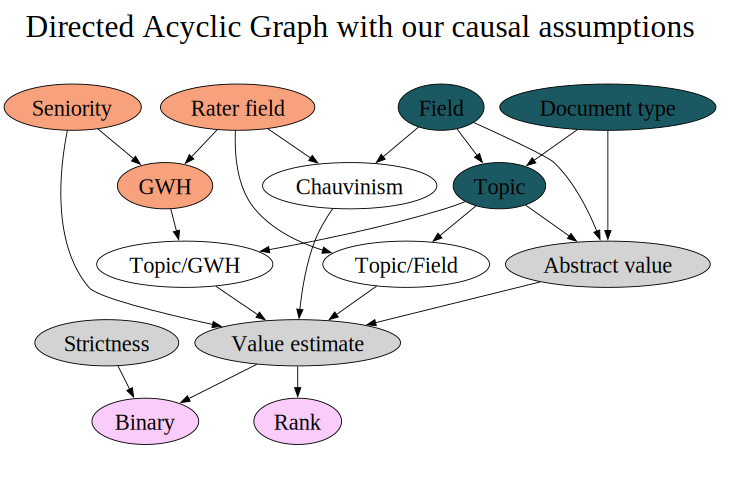

In [171]:
shortDag = CausalGraphicalModel(nodes=nodes, edges=edges)

rater_color = color_list2[7]
abstract_color = color_list2[2]
outcome_color = color_list2[-1]
unobserved = "lightgrey"


color_map = {
    "Binary": outcome_color,
    "Rank": outcome_color,
    "Value estimate": unobserved,
    "Abstract value": unobserved,
    "Strictness": unobserved,
    "Field": abstract_color,
    "Topic": abstract_color,
    "GWH": rater_color,
    "Rater field": rater_color,
    "Seniority": rater_color,
    "Document type": abstract_color,
    "Chauvinism": "white",
    "Topic/Field": "white",
    "Topic/GWH": "white",
}

# adapted draw such that it includes colors
a = shortDag.draw2(color_map=color_map)
a.graph_attr.update(size="10,10")
a.graph_attr.update(
    label="Directed Acyclic Graph with our causal assumptions\n\n",
    fontsize="35",
    labelloc="t",
    margin="0.5,0.5",
)
node_fontsize = 25  # Adjust the font size as needed

for node in color_map.keys():
    a.node(
        node,
        _attributes={
            "fontsize": str(node_fontsize),
            "fillcolor": color_map[node],
            "style": "filled",
        },
    )

output_file = r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\DAG"
a.render(filename=output_file, format="tiff", cleanup=True)
a

Our main variables of interest are:

- Chauvinism
- Strictness
- Field
- Topic codes

For chauvinism, field and the topic codes we will need three separate models. Strictness can be estimated by any of these.

Based on the cell below, we need to add the following variables in our linear model in order to estimate the total causal effect of those particular variables. Note, these are the variables we need to add to get an estimate of the total causal effect. So, for 'field', the effects of the topic variables would be included as they are themselves caused by field.

- Chauvinism: chauvinism, field and rater field
- Field: field
- Topic: topic, document type and field.

In [172]:
for i in ["Chauvinism", "Topic", "Field", "Strictness"]:
    print(f"{i}:")
    backdoor(shortDag, i, "Binary")
    print("")

Chauvinism:
frozenset({'Field', 'Topic', 'Seniority', 'Topic/GWH', 'Topic/Field'})
frozenset({'Rater field', 'Abstract value', 'GWH', 'Topic/GWH', 'Topic/Field'})
frozenset({'Field', 'Topic', 'Seniority', 'GWH', 'Topic/Field'})
frozenset({'Topic', 'Seniority', 'Abstract value', 'GWH', 'Topic/Field'})
frozenset({'Topic/Field', 'Seniority', 'Abstract value', 'Topic/GWH'})
frozenset({'Rater field', 'Topic', 'Abstract value'})
frozenset({'Rater field', 'Field'})

Topic:
frozenset({'Document type', 'Field'})

Field:
frozenset()

Strictness:
frozenset()



These DAGs collaps all topic variables. However, these too have an internal causal structure. More precisely, we assume a relation between "Recent", "Empirical" and "Deliverable". We assume they are related to each other, and to the outcome variables, as illustrated below. The implication of this is that to get the total causal effect of "Deliverable" and "Empirical", we cannot control for "Recent". To get the total causal effect of "Recent", we have to control for "Deliverable" and "Empirical". Because of this, we remove "Recent" from the topic codes in the three main models.

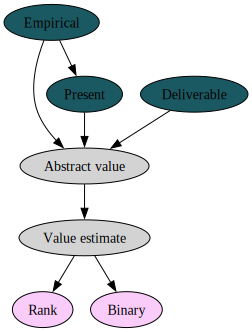

In [173]:
abstract_color = color_list2[2]
outcome_color = color_list2[-1]
unobserved = "lightgrey"

contentDag = CausalGraphicalModel(
    nodes=[
        "Present",
        "Empirical",
        "Value estimate",
        "Binary",
        "Abstract value",
        "Deliverable",
        "Rank",
    ],
    edges=[
        ("Deliverable", "present"),
        ("Deliverable", "Abstract value"),
        ("Empirical", "Present"),
        ("Present", "Abstract value"),
        ("Empirical", "Abstract value"),
        ("Value estimate", "Binary"),
        ("Value estimate", "Rank"),
        ("Abstract value", "Value estimate"),
    ],
)

color_map = {
    "Binary": outcome_color,
    "Rank": outcome_color,
    "Value estimate": "lightgrey",
    "Abstract value": "lightgrey",
    "Deliverable": abstract_color,
    "Empirical": abstract_color,
    "Present": abstract_color,
}


contentDag.draw2(color_map=color_map)

In [6]:
# remove present
content_codes = [i for i in content_codes if i != "present"]

# Notes

- We tested all models with a different intercept for each paper, and with a shared single intercept. The ones with the varying intercept clearly outperformed the ones with the fixed intercept on common metrics for model comparison. This is to be expected, as we expect the value of the papers (beyond what can be captured by the parameters we have) to vary widely. The varying paper intercept captures this difference between papers beyond the field and topic parameters.

- For all models, we tested adding a hyperprior for the sd of paper_intercepts, but while this made sampling slower, it did not change the outcomes substantially. We have therefore not kept this in the model.

- We ran these models for all data (as we do here below), and for just the 3rd study. We did this to check whether the results from studies 1 and 2, which helped to inform our expectations and final changes to the analysis code, would be confirmed by the third group. Since this was the case, and the entire study is exploratory rather than really hypothesis testing, we report on the joint model of all three groups in the paper. Since this model covers a lot more data, it's estimates should be more precise.

# The Topics model

## The model

To estimate the causal effect of the topic codes, we need to include Fields (i.e. the field an abstract is from), Document type (i.e. book or journal abstract) and the Topic codes themselves into the model.

In [192]:
# prep data with the functions from above

mData = prep_data_thurston(df, "main")
g1Data = prep_data_thurston(df, "group1")
g2Data = prep_data_thurston(df, "group2")

# number of fields
K = 5

# dimensions of the data
# i.e. numbers of raters and blocks
mJ = len(df.loc[df.group == "main"]["rater"].unique())
g1J = len(df.loc[df.group == "group1"]["rater"].unique())
g2J = len(df.loc[df.group == "group2"]["rater"].unique())

mB = len(df.loc[df.group == "main"]["block"].unique())
g1B = len(df.loc[df.group == "group1"]["block"].unique())
g2B = len(df.loc[df.group == "group1"]["block"].unique())

$$
\text{binary}_{i} \sim \text{Bernoulli}(p_{i})
$$

$$
$$


$$
\text{logit}(p_{i}) = \text{latent}_{j[i]} + \text{strictness}_{r[i]}
$$

$$
\text{content}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{fields}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{paper\_intercepts}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{paper\_values}_{j[i]} = \text{paper\_intercepts}_{j[i]} + \text{fields}_{j[i]} + \text{content}_{j[i]}
$$

$$
\sigma \sim \text{Uniform}(0.01, 2)
$$

$$
\text{latent}_{j[i]} \sim \text{Normal}(\text{paper\_values}_{j[i]}, \sigma)
$$

$$
\text{strictness\_sd} \sim \text{Uniform}(0.01, 2)
$$

$$
\text{strictness\_offset}_{r[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{strictness}_{r[i]} = \text{strictness\_offset}_{r[i]} \cdot \text{strictness\_sd}
$$

**where:**

- $ \text{binary}_{i} $: Binary outcome for rating $ i $.
- $ p_{i} $: Probability of "1" for the relevance rating $ i $.
- $ \text{latent}_{j[i]} $: Relevance estimate for document $ j $, indexed by rating $ i $. This variable corresponds to the (unconscious) continuous estimate that a rater makes of a document's relevance. In the model, we enforce the order of the estimates of $ \text{latent}_{j[i]} $ in groups of 5 (i.e. the sets that the raters were given) on the basis of the observed rank data. In other words, this is the relevance value estimated by the rater, which is influenced by the 'true' value as well as by other factors.
- $ \text{strictness}_{r[i]} $: Strictness level for rater $ r $, indexed by rating $ i $.
- $ \text{fields}_{j[i]} $: Fields effect for document $ j $, indexed by rating $ i $.
- $ \text{content}_{j[i]} $: Variables for the subject topics, indexed by rating $ i $. This is a vector of 8 variables, one for each of the binary coded subject topics.
- $ \text{paper\_intercepts}_{j[i]} $: Intercept for document $ j $, indexed by rating $ i $.
- $ \text{paper\_values}_{j[i]} $: Combined intercept, content and fields effect for document $ j $, indexed by rating $ i $. Together these make up the 'true' continuous relevance value of the document. 
- $ \sigma $: Standard deviation for the normal distribution of the latent variable. This captures how far raters' value estimates are distributed around the expected (on the basis of rater and document characteristics) value estimates.
- $ \text{strictness\_sd} $: Hyperprior to estimate the extent to which raters differ in strictness. There is no hyperprior for the mean of the strictness parameters. Instead, we set the mean at 0, assuming that the mean of the population is the 'correct' level of strictness (reflecting the fact that there isn't really a true fact of the matter). 
- $ \text{strictness}_{r[i]} $: Strictness parameter that varies by rater $ r $, indexed by rating $ i $. To make sampling easier and faster, the parametrization of this variable is 'non-centered', i.e. using an offset that is scaled by the standard deviation, and captures how much the strictness deviates from the mean. See [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for more on this.

In [193]:
with pm.Model() as content_thurstonian_all:

    # topic code data for the abstracts
    mCONTENT = pm.MutableData("mCONTENT", mData["content_presence"])
    g1CONTENT = pm.MutableData("g1CONTENT", g1Data["content_presence"])
    g2CONTENT = pm.MutableData("g2CONTENT", g2Data["content_presence"])

    # topic code parameters
    # one for each topic code
    content = pm.Normal("content", 0, 1, shape=(len(content_codes)))

    # dot product for the linear model
    # one for each of the three groups
    mdot_prod = pt.dot(mCONTENT, content)
    mdot_prod_reshaped = mdot_prod.reshape((mB, K))

    g1dot_prod = pt.dot(g1CONTENT, content)
    g1dot_prod_reshaped = g1dot_prod.reshape((g1B, K))

    g2dot_prod = pt.dot(g2CONTENT, content)
    g2dot_prod_reshaped = g2dot_prod.reshape((g2B, K))

    # fields parameter
    # one for each field
    fields = pm.Normal("fields", 0, 1, shape=(K))

    # doctype parameter
    # 1 == book
    doctype = pm.Normal("doctype", 0, 1)

    # varying intercepts, one for each document
    paper_intercepts = pm.Normal("paper_intercepts", 0, 1, shape=(mB + g1B + g2B) * K)

    # split the intercepts by group, and put them in the right shape by block
    m_intercepts = paper_intercepts[: mB * K].reshape((mB, K))
    g1_intercepts = paper_intercepts[mB * K : (mB * K) + (g1B * K)].reshape((g1B, K))
    g2_intercepts = paper_intercepts[(mB * K) + (g1B * K) :].reshape((g2B, K))

    # paper value is determined by intercept, field, topics, and doctype
    # one set for each group
    # field, topic and doctype parameters are shared
    mpaper_values = pm.Deterministic(
        "mpaper_values",
        m_intercepts
        + fields[mData["fields_presence"]]
        + mdot_prod_reshaped
        + (doctype * mData["doctype"].reshape((mB, K))),
    )
    g1paper_values = pm.Deterministic(
        "g1paper_values",
        g1_intercepts
        + fields[g1Data["fields_presence"]]
        + g1dot_prod_reshaped
        + (doctype * g1Data["doctype"].reshape((g1B, K))),
    )
    g2paper_values = pm.Deterministic(
        "g2paper_values",
        g2_intercepts
        + fields[g2Data["fields_presence"]]
        + g2dot_prod_reshaped
        + (doctype * g2Data["doctype"].reshape((g2B, K))),
    )

    # each document is rated by multiple raters
    # we need a parameter for each rating, so tile the paper values
    mmu = pm.Deterministic("mmu", pt.tile(mpaper_values[:, pt.newaxis, :], (1, mJ, 1)))
    g1mu = pm.Deterministic(
        "g1mu", pt.tile(g1paper_values[:, pt.newaxis, :], (1, g1J, 1))
    )
    g2mu = pm.Deterministic(
        "g2mu", pt.tile(g2paper_values[:, pt.newaxis, :], (1, g2J, 1))
    )

    # reorder this using the rank data
    # we use this to tell the model how each rater ranked each set
    mreordered_mu = pm.Deterministic(
        "mreordered_mu", pt.take_along_axis(mmu, mData["rank_data_argsort"], axis=-1)
    )
    g1reordered_mu = pm.Deterministic(
        "g1reordered_mu", pt.take_along_axis(g1mu, g1Data["rank_data_argsort"], axis=-1)
    )
    g2reordered_mu = pm.Deterministic(
        "g2reordered_mu", pt.take_along_axis(g2mu, g2Data["rank_data_argsort"], axis=-1)
    )

    # one sd for all ratings
    # we experimented varying it by rater
    sigma = pm.Uniform("sigma", 0.01, 2)

    mlatent = pm.Normal(
        "mlatent",
        mu=mreordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(mB, mJ, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1)),
    )

    g1latent = pm.Normal(
        "g1latent",
        mu=g1reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g1B, g1J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)),
    )

    g2latent = pm.Normal(
        "latent",
        mu=g2reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g2B, g2J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)),
    )

    # now reshape it again
    # this is the order from the original data
    # we need this for the bernoulli/binary data
    mlatent_reshaped = pt.take_along_axis(mlatent, mData["rank_data"], axis=-1)
    g1latent_reshaped = pt.take_along_axis(g1latent, g1Data["rank_data"], axis=-1)
    g2latent_reshaped = pt.take_along_axis(g2latent, g2Data["rank_data"], axis=-1)

    # non-centered parametrization Strictness
    # hyperprior sd
    strictness_sd = pm.Uniform("strictness_sd", 0.01, 2)

    # one offset for each rater
    strictness_offset1 = pm.Normal("strictness_offset1", 0, 1, shape=(1, mJ, 1))
    strictness_offset2 = pm.Normal("strictness_offset2", 0, 1, shape=(1, g1J, 1))
    strictness_offset3 = pm.Normal("strictness_offset3", 0, 1, shape=(1, g2J, 1))

    mstrictness = pm.Deterministic("mstrictness", strictness_offset1 * strictness_sd)
    g1strictness = pm.Deterministic("g1strictness", strictness_offset2 * strictness_sd)
    g2strictness = pm.Deterministic("g2strictness", strictness_offset3 * strictness_sd)

    # the probability of getting a 1 is determined by
    # the estimated paper value and by rater strictness
    mbinary = pm.Bernoulli(
        "mbinary", logit_p=mlatent_reshaped + mstrictness, observed=mData["binary_data"]
    )
    g1binary = pm.Bernoulli(
        "g1binary",
        logit_p=g1latent_reshaped + g1strictness,
        observed=g1Data["binary_data"],
    )
    g2binary = pm.Bernoulli(
        "g2binary",
        logit_p=g2latent_reshaped + g2strictness,
        observed=g2Data["binary_data"],
    )

    # prior predictive sampling used to set priors
    pr9 = pm.sample_prior_predictive()

Sampling: [content, doctype, fields, g1binary, g1latent, g2binary, latent, mbinary, mlatent, paper_intercepts, sigma, strictness_offset1, strictness_offset2, strictness_offset3, strictness_sd]


## Sampling

In [194]:
# sample from the posterior
with content_thurstonian_all:
    trace_content_thurstonian_all = pm.sample(
        10000, tune=1500, idata_kwargs={"log_likelihood": True}, target_accept=0.8
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, fields, doctype, paper_intercepts, sigma, mlatent, g1latent, latent, strictness_sd, strictness_offset1, strictness_offset2, strictness_offset3]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 5267 seconds.


In [196]:
# save the trace
trace_content_thurstonian_all.to_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all.nc"
)

# load the trace

# trace_content_thurstonian_all = az.from_netcdf(
#     r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all_FINAL.nc"
# )

'C:\\Users\\conix\\Documents\\IIH_localtraces\\trace_content_thurstonian_all.nc'

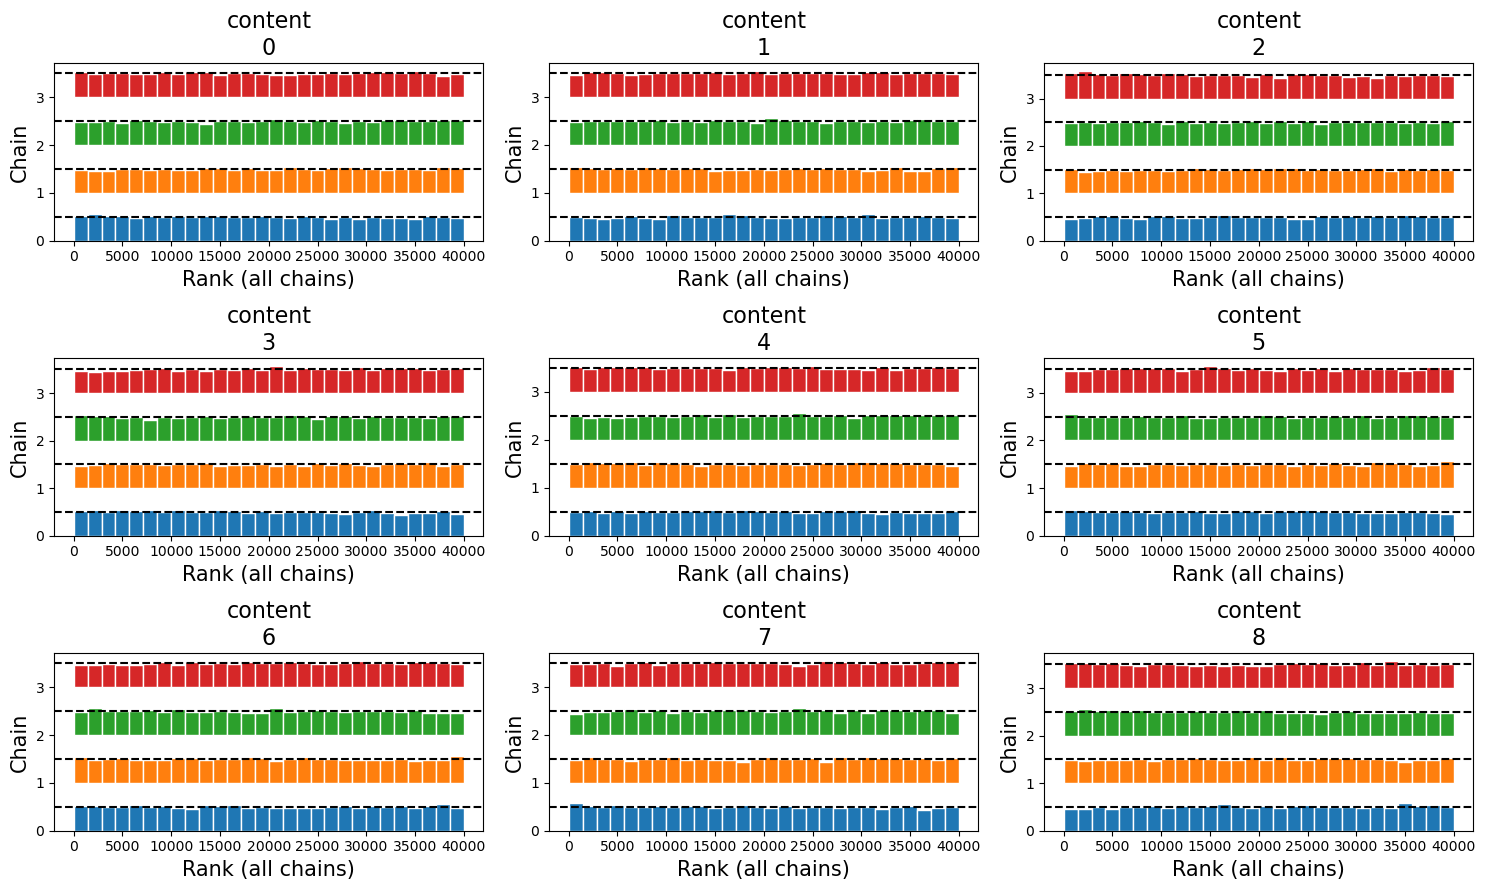

In [178]:
# rank plots for topic
az.plot_rank(trace_content_thurstonian_all, var_names=["content"], figsize=(15, 9))

plt.tight_layout()

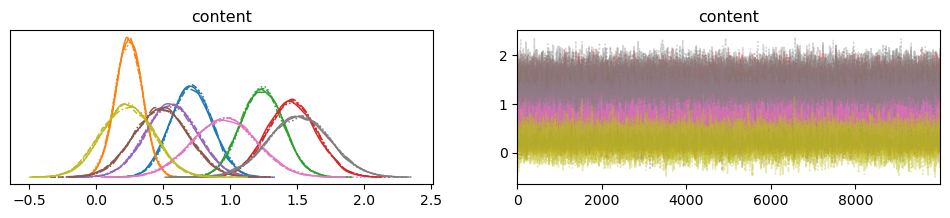

In [179]:
# trace plots for content
# cannot plot trace for all parameters

az.plot_trace(trace_content_thurstonian_all, var_names=["content"])
plt.show()

In [180]:
# main sampling stats content

az.summary(trace_content_thurstonian_all, var_names=["content"]).iloc[:, 4:]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
content[0],0.002,0.001,8732.0,15078.0,1.0
content[1],0.001,0.001,13291.0,21565.0,1.0
content[2],0.001,0.001,13924.0,21536.0,1.0
content[3],0.002,0.001,13684.0,22549.0,1.0
content[4],0.002,0.001,12129.0,20460.0,1.0
content[5],0.002,0.001,14798.0,22106.0,1.0
content[6],0.002,0.001,15054.0,23920.0,1.0
content[7],0.002,0.001,14207.0,22674.0,1.0
content[8],0.002,0.001,12452.0,20619.0,1.0


In [181]:
# check rhats and divergences

# rhats
vars = [
    "content",
    "fields",
    "doctype",
    "paper_intercepts",
    "strictness_sd",
    "strictness_offset1",
    "strictness_offset2",
    "strictness_offset3",
]
summary = az.summary(trace_content_thurstonian_all, var_names=vars)
high_rhats = [i for i in summary["r_hat"] if i > 1.0]
if len(high_rhats) > 0:
    print(
        f"Prop of rhats > 1: {(len(high_rhats) / len(summary)):.2f}; Highest rhat: {np.array(high_rhats).max()}"
    )
else:
    print("No rhats higher than 1.0")

# divergences
divergences = trace_content_thurstonian_all.sample_stats["diverging"]
print(f"Nr of divergencs: {divergences.sum().values}")

Prop of rhats > 1: 0.02; Highest rhat: 1.01
Nr of divergencs: 0


## Results

In [183]:
summary = az.summary(trace_content_thurstonian_all, var_names=["content"])
summary.index = content_codes
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
content[0],0.712,0.154,0.426,1.004,0.002,0.001,8732.0,15078.0,1.0
content[1],0.244,0.102,0.052,0.440,0.001,0.001,13291.0,21565.0,1.0
content[2],1.237,0.159,0.936,1.530,0.001,0.001,13924.0,21536.0,1.0
content[3],1.458,0.187,1.107,1.810,0.002,0.001,13684.0,22549.0,1.0
content[4],0.563,0.192,0.198,0.917,0.002,0.001,12129.0,20460.0,1.0
content[5],0.485,0.205,0.105,0.872,0.002,0.001,14798.0,22106.0,1.0
content[6],0.957,0.239,0.509,1.406,0.002,0.001,15054.0,23920.0,1.0
content[7],1.513,0.229,1.077,1.936,0.002,0.001,14207.0,22674.0,1.0
content[8],0.234,0.194,-0.137,0.588,0.002,0.001,12452.0,20619.0,1.0


In [185]:
fig, ax = plt.subplots(figsize=(10, 4))
az.plot_forest(
    trace_content_thurstonian_all, var_names=["content"], combined=True, ax=ax
)
content_codes_r = list(reversed(content_codes))
ax.set_yticklabels(content_codes_r)
plt.show()

# Chauvinism Model

Our DAG shows we have to include chauvinism, rater_field and field to estimate the effect of chauvinism.

$$
\text{binary}_{i} \sim \text{Bernoulli}(p_{i})
$$

$$
$$


$$
\text{logit}(p_{i}) = \text{latent}_{j[i]} + \text{strictness}_{r[i]}
$$

$$
\text{rater\_field}_{[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{fields}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{chauvinism\_mean} \sim \text{Normal}(0, 1)
$$

$$
\text{chauvinism\_sd} \sim \text{Uniform}(0.01, 2)
$$

$$
\text{chauvinism\_offset}_{r[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{chauvinism}_{j[i]} = \text{chauvinism\_mean} + \text{chauvinism\_sd} \cdot \text{chauvinism\_offset}_{r[i]}
$$

$$
\text{paper\_intercepts}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{paper\_values}_{j[i]} = \text{paper\_intercepts}_{j[i]} + \text{fields}_{j[i]}
$$

$$
\sigma \sim \text{Uniform}(0.01, 2)
$$

$$
\text{latent}_{j[i]} \sim \text{Normal}(\text{paper\_values}_{j[i]}, \sigma) + \text{rater\_field}_{r[i]} + \text{chauvinism}_{j[i]}
$$

$$
\text{strictness\_sd} \sim \text{Uniform}(0.01, 2)
$$

$$
\text{strictness\_offset}_{r[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{strictness}_{r[i]} = \text{strictness\_offset}_{r[i]} \cdot \text{strictness\_sd}
$$

**where:**

- $ \text{binary}_{i} $: Binary outcome for rating $ i $.
- $ p_{i} $: Probability of "1" for the relevance rating $ i $.
- $ \text{latent}_{j[i]} $: Relevance estimate for document $ j $, indexed by rating $ i $. This variable corresponds to the (unconscious) continuous estimate that a rater makes of a document's relevance. In the model, we enforce the order of the estimates of $ \text{latent}_{j[i]} $ in groups of 5 (i.e. the sets that the raters were given) on the basis of the observed rank data. In other words, this is the relevance value estimated by the rater, which is influenced by the 'true' value as well as by other factors.
- $ \text{strictness}_{r[i]} $: Strictness level for rater $ r $, indexed by rating $ i $.
- $ \text{fields}_{j[i]} $: Fields effect for document $ j $, indexed by rating $ i $.
- $ \text{rater\_field}_{[i]} $: rater field effect indexed by rating $ i $.
- $ \text{chauvinism}_{j[i]} $: Chauvinism effect for rater $ r $, indexed by rating $ i $.
- $ \text{chauvinism\_mean} $: Hyperprior for estimating the mean chauvinism effect.
- $ \text{chauvinism\_sd} $: Hyperprior for estimating the extent to which raters differ in how chauvinistic they are.
- $ \text{chauvinism\_offset}_{r[i]} $: Chauvinism offset for rater $ r $, indexed by rating $ i $. This is used for the non-centered parametrization.
- $ \text{paper\_intercepts}_{j[i]} $: Intercept for document $ j $, indexed by rating $ i $.
- $ \text{paper\_values}_{j[i]} $: Combined intercept and fields effect for document $ j $, indexed by rating $ i $. Together these make up the 'true' continuous relevance value of the document. 
- $ \sigma $: Standard deviation for the normal distribution of the latent variable. This captures how far raters' value estimates are distributed around the expected (on the basis of rater and document characteristics) value estimates.
- $ \text{strictness\_sd} $: Hyperprior to estimate the extent to which raters differ in strictness. There is no hyperprior for the mean of the strictness parameters. Instead, we set the mean at 0, assuming that the mean of the population is the 'correct' level of strictness (reflecting the fact that there isn't really a true fact of the matter). 
- $ \text{strictness}_{r[i]} $: Strictness parameter that varies by rater $ r $, indexed by rating $ i $. To make sampling easier and faster, the parametrization of this variable is 'non-centered', i.e. using an offset that is scaled by the standard deviation, and captures how much the strictness deviates from the mean. See [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for more on this.

In [118]:
# prepare data with the function from above
mData = prep_data_thurston(df, "main")
g1Data = prep_data_thurston(df, "group1")
g2Data = prep_data_thurston(df, "group2")

# the number of humanities and non-hum raters
# need this because non-hum has no chauvinism
J_hum = 11
J_non_hum = 11

# the other dimensions
mJ = len(df.loc[df.group == "main"]["rater"].unique())
g1J = len(df.loc[df.group == "group1"]["rater"].unique())
g2J = len(df.loc[df.group == "group2"]["rater"].unique())

mB = len(df.loc[df.group == "main"]["block"].unique())
g1B = len(df.loc[df.group == "group1"]["block"].unique())
g2B = len(df.loc[df.group == "group1"]["block"].unique())

# number of fields
K = 5

In [30]:
with pm.Model() as chauvinism_thurstonian_all:

    # rater field parameter
    # one for each field + one for non-hum
    rater_field = pm.Normal("rater_field", 0, 1, shape=K + 1)

    # fields parameters
    fields = pm.Normal("fields", 0, 1, shape=(K))

    # one paper intercept for each doc
    paper_intercepts = pm.Normal("paper_intercepts", 0, 1, shape=(mB + g1B + g2B) * K)

    # split the intercepts by group, and put them in the right shape by block
    m_intercepts = paper_intercepts[: mB * K].reshape((mB, K))
    g1_intercepts = paper_intercepts[mB * K : (mB * K) + (g1B * K)].reshape((g1B, K))
    g2_intercepts = paper_intercepts[(mB * K) + (g1B * K) :].reshape((g2B, K))

    # Non-centered parameterization for chauvinism

    # the hyperpriors
    chauv_mean = pm.Normal("chauv_mean", 0, 1)
    chauv_sd = pm.Uniform("chauv_sd", 0.01, 2)

    # need just zeros for the non-hum, as they cannot be chauvinistic
    c_offset_nonhum = pt.zeros((1, J_non_hum, 1))

    # one offset for each hum rater
    # separeted by group
    mchauvinism_offset = pm.Normal("mchauvinism_offset", 0, 1, shape=(1, J_hum, 1))
    chauvinism_hum = pm.Deterministic(
        "chauvinism_hum", chauv_mean + chauv_sd * mchauvinism_offset
    )
    mchauvinism = pt.concatenate([chauvinism_hum, c_offset_nonhum], axis=1)

    g1chauvinism_offset = pm.Normal("g1chauvinism_offset", 0, 1, shape=(1, g1J, 1))
    g1chauvinism = pm.Deterministic(
        "g1chauvinism", chauv_mean + chauv_sd * g1chauvinism_offset
    )

    g2chauvinism_offset = pm.Normal("g2chauvinism_offset", 0, 1, shape=(1, g2J, 1))
    g2chauvinism = pm.Deterministic(
        "g2chauvinism", chauv_mean + chauv_sd * g2chauvinism_offset
    )

    # paper values determined by field and intercept
    mpaper_values = pm.Deterministic(
        "mpaper_values", m_intercepts + fields[mData["fields_presence"]]
    )
    g1paper_values = pm.Deterministic(
        "g1paper_values", g1_intercepts + fields[g1Data["fields_presence"]]
    )
    g2paper_values = pm.Deterministic(
        "g2paper_values", g2_intercepts + fields[g2Data["fields_presence"]]
    )

    # tile because each doc rater by multiple raters
    mmu = pm.Deterministic(
        "mmu",
        pt.tile(mpaper_values[:, pt.newaxis, :], (1, mJ, 1))
        + rater_field[mData["rater_fields"]]
        + (mData["chauv_array"] * mchauvinism),
    )
    g1mu = pm.Deterministic(
        "g1mu",
        pt.tile(g1paper_values[:, pt.newaxis, :], (1, g1J, 1))
        + rater_field[g1Data["rater_fields"]]
        + (g1Data["chauv_array"] * g1chauvinism),
    )
    g2mu = pm.Deterministic(
        "g2mu",
        pt.tile(g2paper_values[:, pt.newaxis, :], (1, g2J, 1))
        + rater_field[g2Data["rater_fields"]]
        + (g2Data["chauv_array"] * g2chauvinism),
    )

    # reorder by rank scores
    # this way the model knows how the estimates are ranked
    mreordered_mu = pm.Deterministic(
        "mreordered_mu", pt.take_along_axis(mmu, mData["rank_data_argsort"], axis=-1)
    )
    g1reordered_mu = pm.Deterministic(
        "g1reordered_mu", pt.take_along_axis(g1mu, g1Data["rank_data_argsort"], axis=-1)
    )
    g2reordered_mu = pm.Deterministic(
        "g2reordered_mu", pt.take_along_axis(g2mu, g2Data["rank_data_argsort"], axis=-1)
    )

    # sd for the estimates
    sigma = pm.Uniform("sigma", 0.01, 2)

    # the paper value estimates by group
    # the rank data is in here through the way the priors for mu are ordered
    mlatent = pm.Normal(
        "mlatent",
        mu=mreordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(mB, mJ, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1)),
    )

    g1latent = pm.Normal(
        "g1latent",
        mu=g1reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g1B, g1J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)),
    )

    g2latent = pm.Normal(
        "g2latent",
        mu=g2reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g2B, g2J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)),
    )

    # back to the original order
    # this is the order of the binary data
    mlatent_reshaped = pt.take_along_axis(mlatent, mData["rank_data"], axis=-1)
    g1latent_reshaped = pt.take_along_axis(g1latent, g1Data["rank_data"], axis=-1)
    g2latent_reshaped = pt.take_along_axis(g2latent, g2Data["rank_data"], axis=-1)

    # non-centered parametrization for strictness

    # hyperprior
    strictness_sd = pm.Uniform("strictness_sd", 0.01, 2)

    # offsets by group
    strictness_offset1 = pm.Normal("strictness_offset1", 0, 1, shape=(1, mJ, 1))
    strictness_offset2 = pm.Normal("strictness_offset2", 0, 1, shape=(1, g1J, 1))
    strictness_offset3 = pm.Normal("strictness_offset3", 0, 1, shape=(1, g2J, 1))

    mstrictness = pm.Deterministic("mstrictness", strictness_offset1 * strictness_sd)
    g1strictness = pm.Deterministic("g1strictness", strictness_offset2 * strictness_sd)
    g2strictness = pm.Deterministic("g2strictness", strictness_offset3 * strictness_sd)

    # probability of 1 is determined by
    # paper value and rater strictness
    mbinary = pm.Bernoulli(
        "mbinary", logit_p=mlatent_reshaped + mstrictness, observed=mData["binary_data"]
    )
    g1binary = pm.Bernoulli(
        "g1binary",
        logit_p=g1latent_reshaped + g1strictness,
        observed=g1Data["binary_data"],
    )
    g2binary = pm.Bernoulli(
        "g2binary",
        logit_p=g2latent_reshaped + g2strictness,
        observed=g2Data["binary_data"],
    )

    # sample prior predictive to choose the priors
    pr9 = pm.sample_prior_predictive()

Sampling: [chauv_mean, chauv_sd, fields, g1binary, g1chauvinism_offset, g1latent, g2binary, g2chauvinism_offset, g2latent, mbinary, mchauvinism_offset, mlatent, paper_intercepts, rater_field, sigma, strictness_offset1, strictness_offset2, strictness_offset3, strictness_sd]


## Sampling

In [31]:
with chauvinism_thurstonian_all:
    trace_chauvinism_thurstonian_all = pm.sample(
        10000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.8
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rater_field, fields, paper_intercepts, chauv_mean, chauv_sd, mchauvinism_offset, g1chauvinism_offset, g2chauvinism_offset, sigma, mlatent, g1latent, g2latent, strictness_sd, strictness_offset1, strictness_offset2, strictness_offset3]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 5426 seconds.


In [119]:
# save trace
# trace_chauvinism_thurstonian_all.to_netcdf(
#     r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all_Final.nc"
# )

# load trace
trace_chauvinism_thurstonian_all = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all_Final.nc"
)

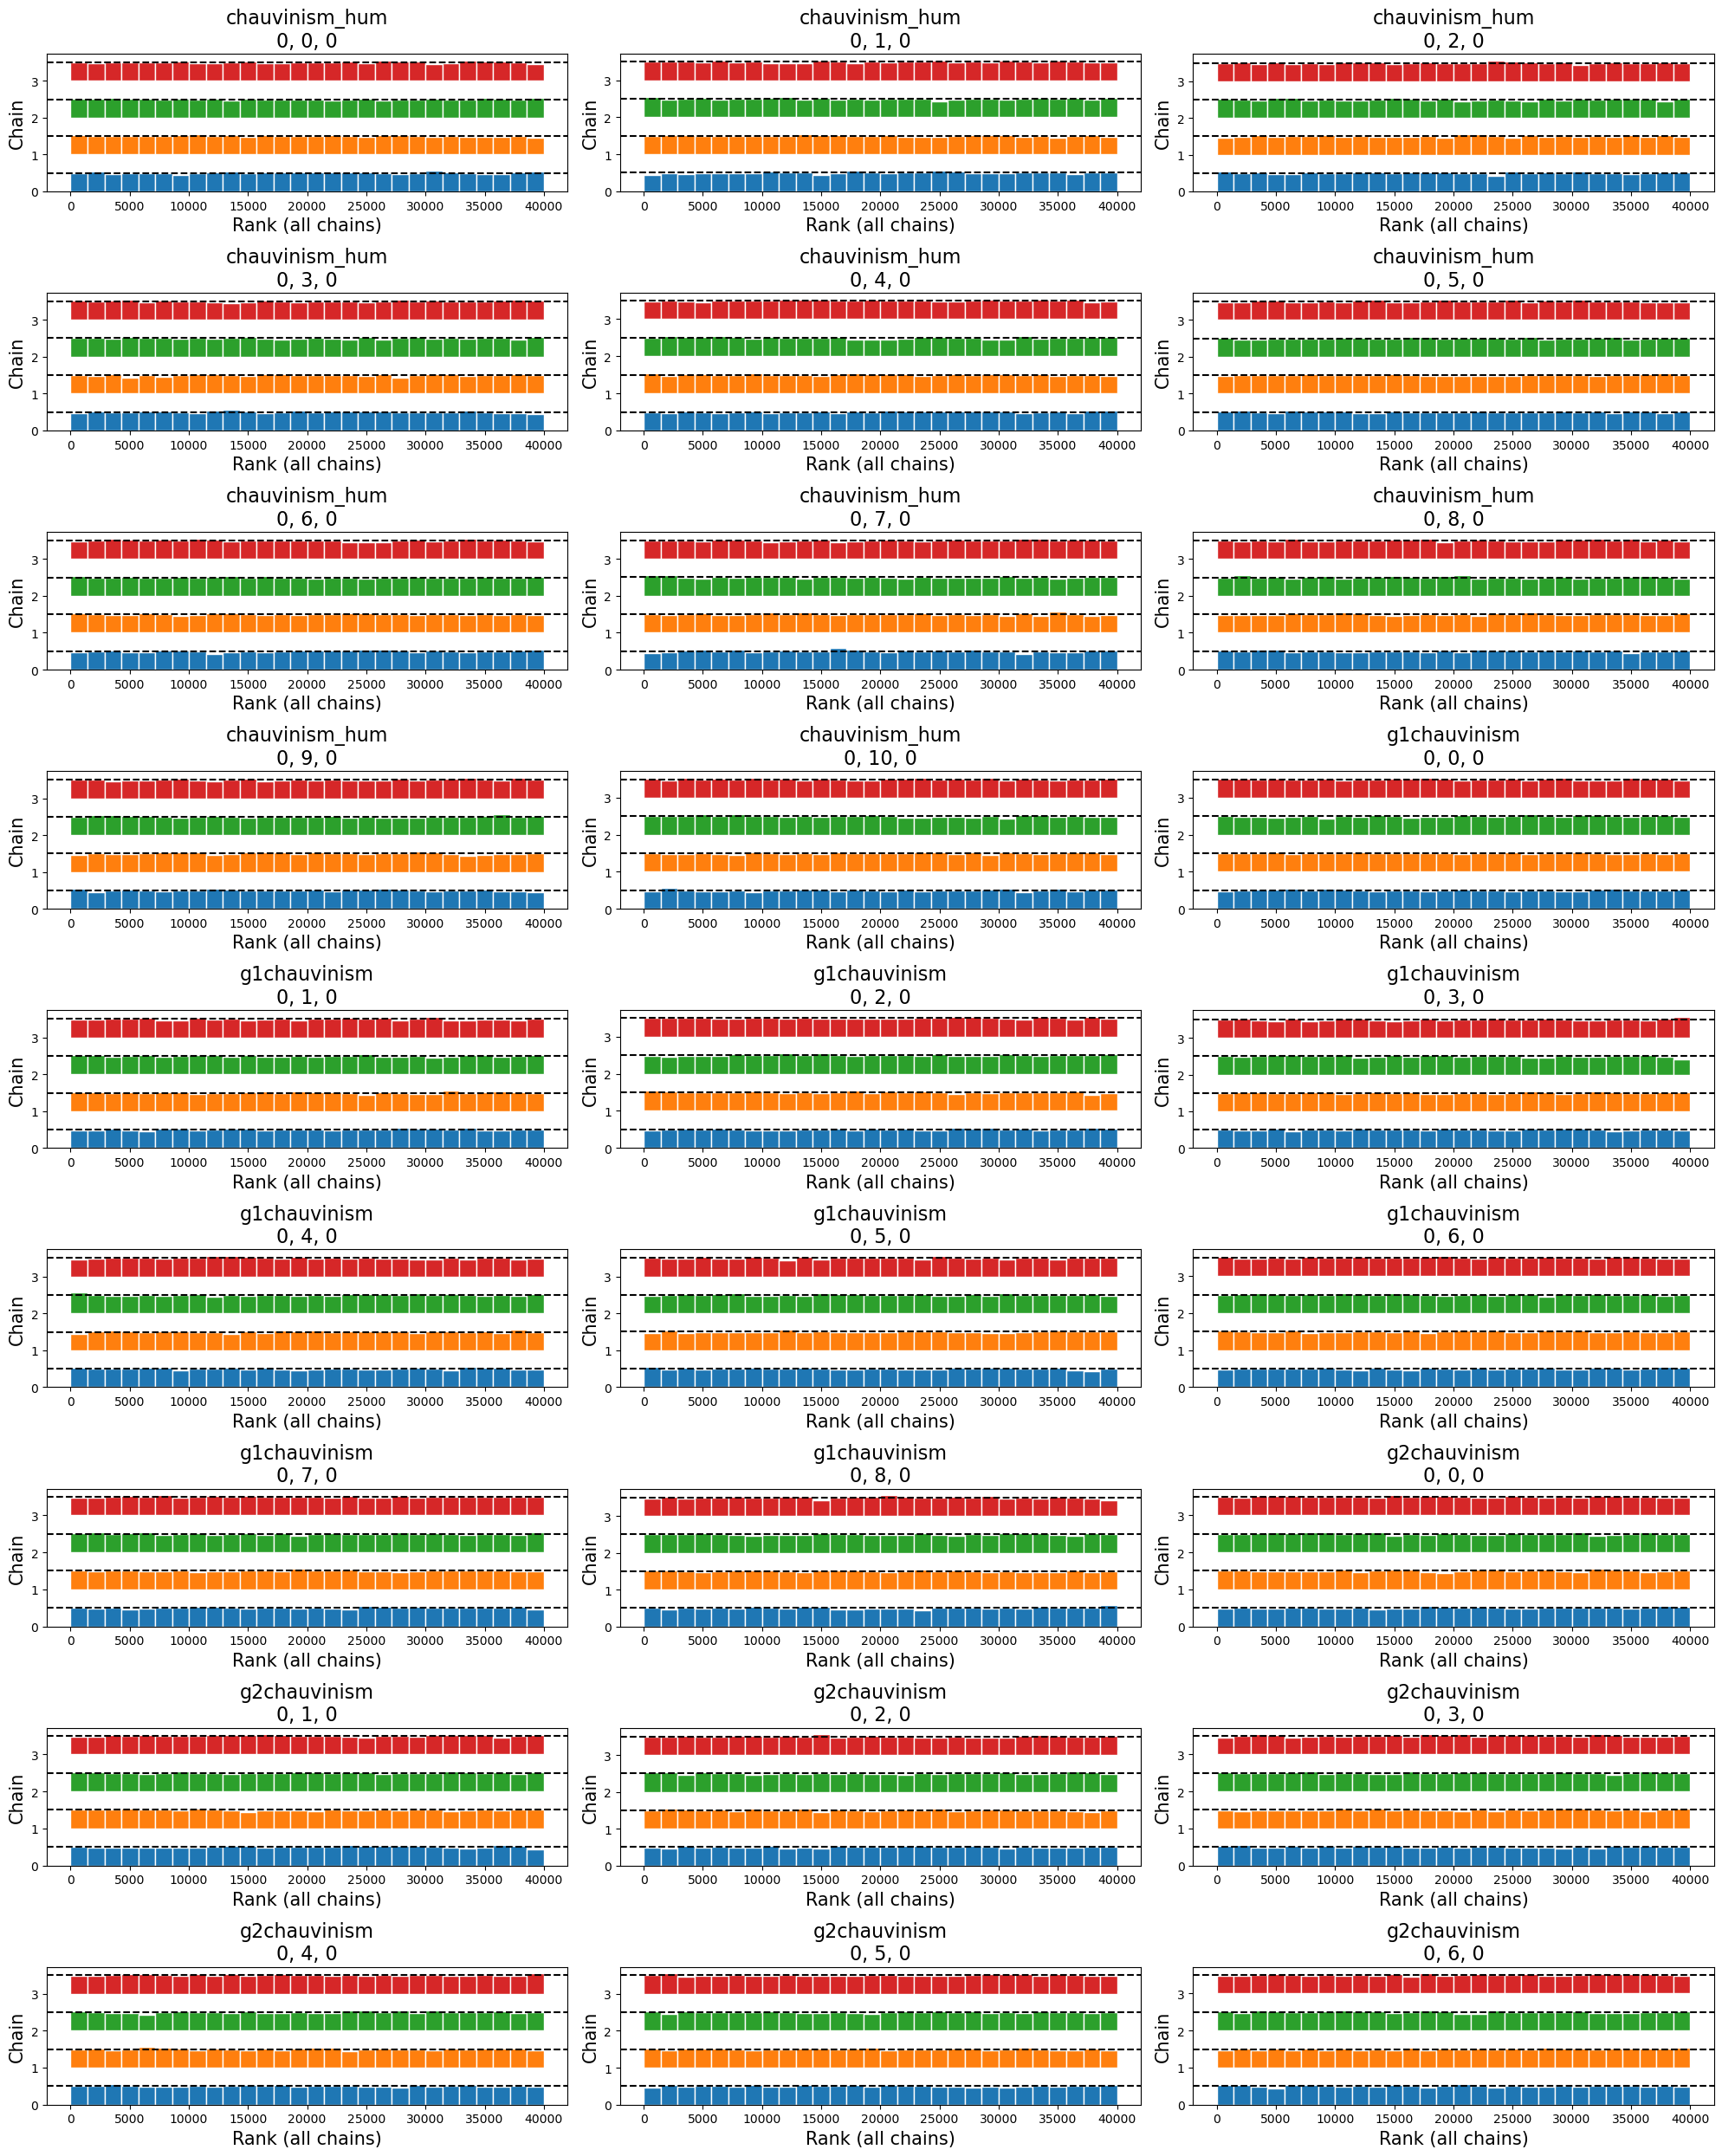

In [122]:
# rank plots for
az.plot_rank(
    trace_chauvinism_thurstonian_all,
    var_names=["chauvinism_hum", "g1chauvinism", "g2chauvinism"],
    figsize=(20, 25),
)

plt.tight_layout()

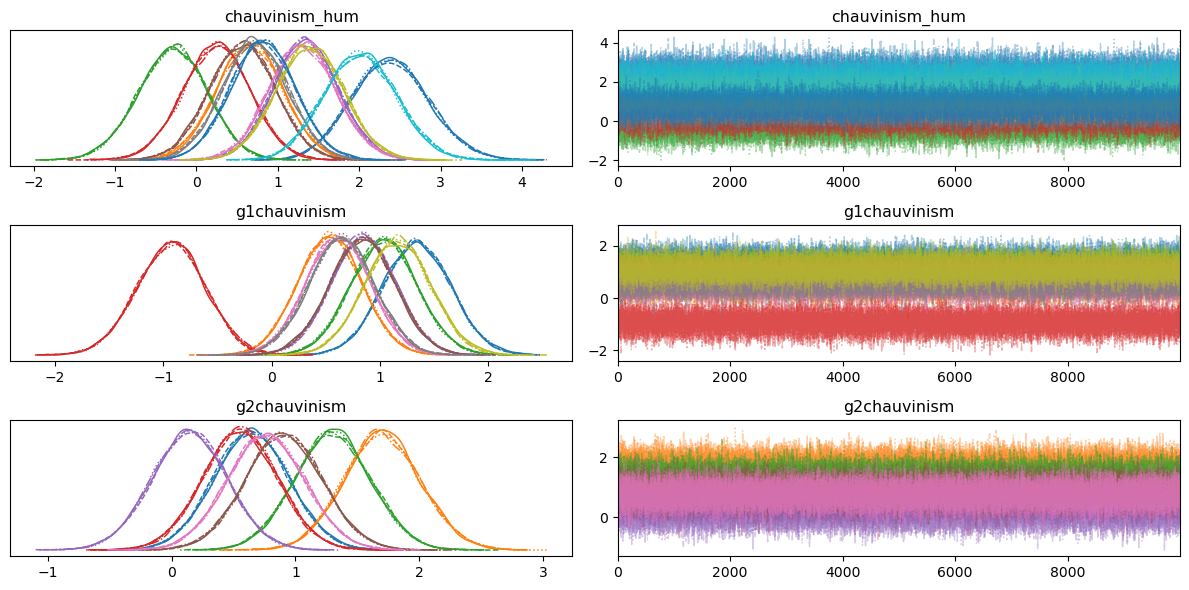

In [125]:
# trace plots for
# cannot plot trace for all parameters

az.plot_trace(
    trace_chauvinism_thurstonian_all,
    var_names=["chauvinism_hum", "g1chauvinism", "g2chauvinism"],
)
plt.tight_layout()

In [126]:
# main sampling stats

az.summary(
    trace_chauvinism_thurstonian_all,
    var_names=["chauvinism_hum", "g1chauvinism", "g2chauvinism"],
).iloc[:, 4:]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chauvinism_hum[0, 0, 0]",0.003,0.002,24216.0,27832.0,1.0
"chauvinism_hum[0, 1, 0]",0.002,0.002,34084.0,30932.0,1.0
"chauvinism_hum[0, 2, 0]",0.002,0.002,28601.0,27245.0,1.0
"chauvinism_hum[0, 3, 0]",0.002,0.002,35218.0,30597.0,1.0
"chauvinism_hum[0, 4, 0]",0.002,0.002,34215.0,30821.0,1.0
"chauvinism_hum[0, 5, 0]",0.002,0.002,28639.0,29970.0,1.0
"chauvinism_hum[0, 6, 0]",0.002,0.002,34702.0,31302.0,1.0
"chauvinism_hum[0, 7, 0]",0.002,0.002,32093.0,29621.0,1.0
"chauvinism_hum[0, 8, 0]",0.002,0.002,31737.0,27996.0,1.0
"chauvinism_hum[0, 9, 0]",0.003,0.002,27943.0,28148.0,1.0


In [129]:
# check rhats and divergences

# rhats
vars = [
    "fields",
    "rater_field",
    "paper_intercepts",
    "strictness_sd",
    "strictness_offset1",
    "strictness_offset2",
    "strictness_offset3",
    "mchauvinism_offset",
    "g1chauvinism_offset",
    "g2chauvinism_offset",
    "chauv_mean",
    "chauv_sd",
]
summary = az.summary(trace_chauvinism_thurstonian_all, var_names=vars)
high_rhats = [i for i in summary["r_hat"] if i > 1.0]
if len(high_rhats) > 0:
    print(
        f"Prop of rhats > 1: {(len(high_rhats) / len(summary)):.2f}; Highest rhat: {np.array(high_rhats).max()}"
    )
else:
    print("No rhats higher than 1.0")

# divergences
divergences = trace_chauvinism_thurstonian_all.sample_stats["diverging"]
print(f"Nr of divergences: {divergences.sum().values}")

Prop of rhats > 1: 0.01; Highest rhat: 1.01
Nr of divergences: 0


## Results

In [136]:
summary = az.summary(
    trace_chauvinism_thurstonian_all,
    var_names=[
        "chauvinism_hum",
        "g1chauvinism",
        "g2chauvinism",
        "chauv_sd",
        "chauv_mean",
    ],
)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chauvinism_hum[0, 0, 0]",2.384,0.473,1.511,3.289,0.003,0.002,24216.0,27832.0,1.0
"chauvinism_hum[0, 1, 0]",0.654,0.410,-0.146,1.399,0.002,0.002,34084.0,30932.0,1.0
"chauvinism_hum[0, 2, 0]",-0.296,0.423,-1.123,0.469,0.002,0.002,28601.0,27245.0,1.0
"chauvinism_hum[0, 3, 0]",0.247,0.414,-0.506,1.053,0.002,0.002,35218.0,30597.0,1.0
"chauvinism_hum[0, 4, 0]",1.347,0.400,0.580,2.085,0.002,0.002,34215.0,30821.0,1.0
"chauvinism_hum[0, 5, 0]",0.563,0.407,-0.192,1.329,0.002,0.002,28639.0,29970.0,1.0
"chauvinism_hum[0, 6, 0]",1.302,0.412,0.540,2.092,0.002,0.002,34702.0,31302.0,1.0
"chauvinism_hum[0, 7, 0]",0.717,0.403,-0.054,1.463,0.002,0.002,32093.0,29621.0,1.0
"chauvinism_hum[0, 8, 0]",1.396,0.416,0.605,2.170,0.002,0.002,31737.0,27996.0,1.0
"chauvinism_hum[0, 9, 0]",2.018,0.445,1.200,2.862,0.003,0.002,27943.0,28148.0,1.0


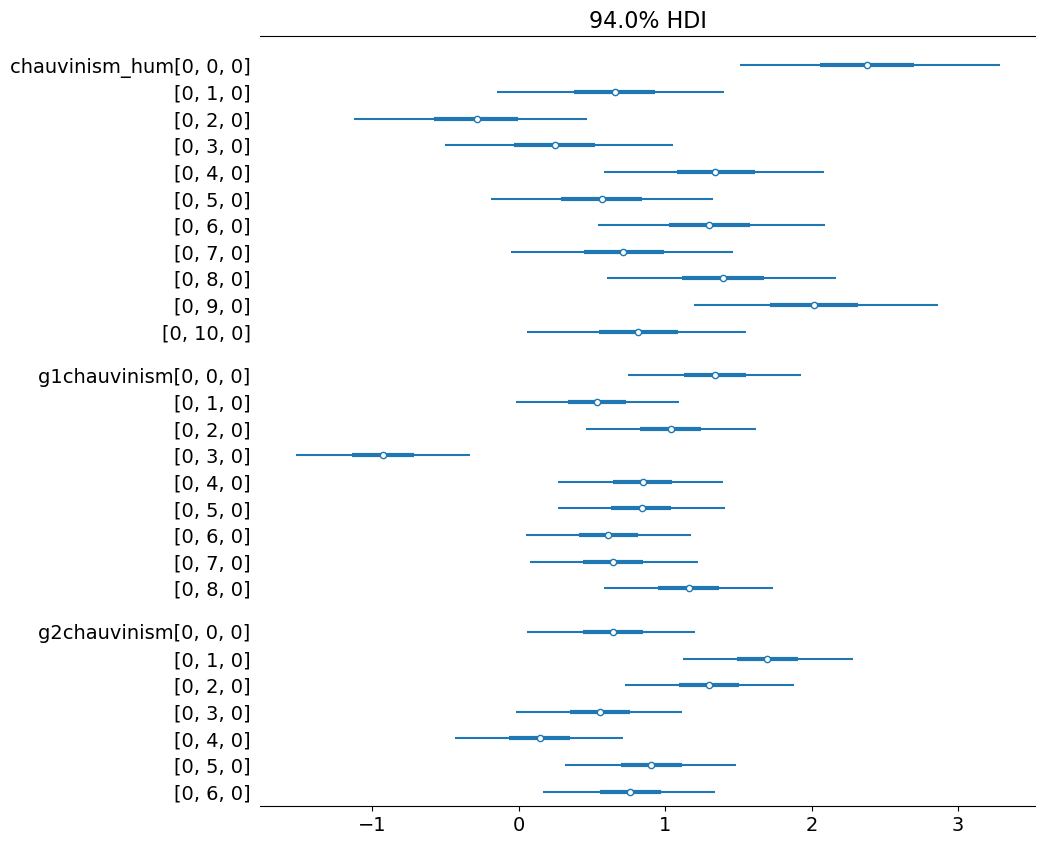

In [135]:
fig, ax = plt.subplots(figsize=(10, 10))
az.plot_forest(
    trace_chauvinism_thurstonian_all,
    var_names=["chauvinism_hum", "g1chauvinism", "g2chauvinism"],
    combined=True,
    ax=ax,
)
plt.show()

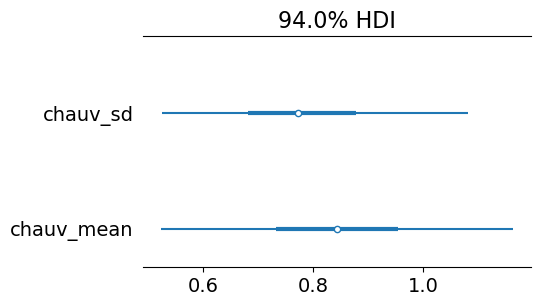

In [141]:
# chauvinism hyperpriors

az.plot_forest(
    trace_chauvinism_thurstonian_all,
    var_names=["chauv_sd", "chauv_mean"],
    figsize=(5, 3),
    combined=True,
)
plt.show()

# Field model

For this model, we only need to include the field variable in the linear model

## The model



$$
\text{binary}_{i} \sim \text{Bernoulli}(p_{i})
$$

$$
$$


$$
\text{logit}(p_{i}) = \text{latent}_{j[i]} + \text{strictness}_{r[i]}
$$

$$
\text{fields}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{paper\_intercepts}_{j[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{paper\_values}_{j[i]} = \text{paper\_intercepts}_{j[i]} + \text{fields}_{j[i]}
$$

$$
\sigma \sim \text{Uniform}(0.01, 2)
$$

$$
\text{latent}_{j[i]} \sim \text{Normal}(\text{paper\_values}_{j[i]}, \sigma)
$$

$$
\text{strictness\_sd} \sim \text{Uniform}(0.01, 2)
$$

$$
\text{strictness\_offset}_{r[i]} \sim \text{Normal}(0, 1)
$$

$$
\text{strictness}_{r[i]} = \text{strictness\_offset}_{r[i]} \cdot \text{strictness\_sd}
$$

**where:**

- $ \text{binary}_{i} $: Binary outcome for rating $ i $.
- $ p_{i} $: Probability of "1" for rating $ i $.
- $ \text{latent}_{j[i]} $: Latent variable for document $ j $, indexed by document $ i $. This variable corresponds to the (unconscious) continuous estimate that a rater makes of a document's relevance. In the model, we enforce the order of the estimates of $ \text{latent}_{j[i]} $ in groups of 5 (i.e. the sets that the raters were given) on the basis of the observed rank data. In other words, this is the relevance value estimated by the rater, which is influenced by the 'true' value as well as by other factors.
- $ \text{strictness}_{r[i]} $: Strictness level for rater $ r $, indexed by rating $ i $.
- $ \text{fields}_{j[i]} $: Fields effect for document $ j $, indexed by rating $ i $.
- $ \text{paper\_intercepts}_{j[i]} $: Intercept for document $ j $, indexed by rating $ i $.
- $ \text{paper\_values}_{j[i]} $: Combined intercept and fields effect for document $ j $, indexed by rating $ i $. Together these make up the 'true' continuous relevance value of the document. 
- $ \sigma $: Standard deviation for the normal distribution of the latent variable. This captures how far raters' value estimates are distributed around the expected (on the basis of rater and document characteristics) value estimates.
- $ \text{strictness\_sd} $: Hyperprior to estimate the extent to which raters differ in strictness. There is no hyperprior for the mean of the strictness parameters. Instead, we set the mean at 0, assuming that the mean of the population is the 'correct' level of strictness (reflecting the fact that there isn't really a true fact of the matter). 
- $ \text{strictness}_{r[i]} $: Strictness parameter that varies by rater $ r $, indexed by rating $ i $. To make sampling easier and faster, the parametrization of this variable is 'non-centered', i.e. using an offset that is scaled by the standard deviation, and captures how much the strictness deviates from the mean. See [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for more on this.

In [7]:
# prepare data
mData = prep_data_thurston(df, "main")
g1Data = prep_data_thurston(df, "group1")
g2Data = prep_data_thurston(df, "group2")

# get the dimensions
mJ = len(df.loc[df.group == "main"]["rater"].unique())
g1J = len(df.loc[df.group == "group1"]["rater"].unique())
g2J = len(df.loc[df.group == "group2"]["rater"].unique())

mB = len(df.loc[df.group == "main"]["block"].unique())
g1B = len(df.loc[df.group == "group1"]["block"].unique())
g2B = len(df.loc[df.group == "group1"]["block"].unique())

# number of docs per set
K = 5

with pm.Model() as field_thurstonian_all:

    # fields parameter
    # one per field
    fields = pm.Normal("fields", 0, 1, shape=(K))

    # varying intercepts for the docs
    paper_intercepts = pm.Normal("paper_intercepts", 0, 1, shape=(mB + g1B + g2B) * K)

    # split the intercepts by group, and put them in the right shape by block
    m_intercepts = paper_intercepts[: mB * K].reshape((mB, K))
    g1_intercepts = paper_intercepts[mB * K : (mB * K) + (g1B * K)].reshape((g1B, K))
    g2_intercepts = paper_intercepts[(mB * K) + (g1B * K) :].reshape((g2B, K))

    # paper value is determined by field and intercept
    mpaper_values = pm.Deterministic(
        "mpaper_values", m_intercepts + fields[mData["fields_presence"]]
    )
    g1paper_values = pm.Deterministic(
        "g1paper_values", g1_intercepts + fields[g1Data["fields_presence"]]
    )
    g2paper_values = pm.Deterministic(
        "g2paper_values", g2_intercepts + fields[g2Data["fields_presence"]]
    )

    # tile these paper values
    # one for each rating
    mmu = pm.Deterministic("mmu", pt.tile(mpaper_values[:, pt.newaxis, :], (1, mJ, 1)))
    g1mu = pm.Deterministic(
        "g1mu", pt.tile(g1paper_values[:, pt.newaxis, :], (1, g1J, 1))
    )
    g2mu = pm.Deterministic(
        "g2mu", pt.tile(g2paper_values[:, pt.newaxis, :], (1, g2J, 1))
    )

    # reorder by rank scores
    # this way the model knows how the docs were ranked
    mreordered_mu = pm.Deterministic(
        "mreordered_mu", pt.take_along_axis(mmu, mData["rank_data_argsort"], axis=-1)
    )
    g1reordered_mu = pm.Deterministic(
        "g1reordered_mu", pt.take_along_axis(g1mu, g1Data["rank_data_argsort"], axis=-1)
    )
    g2reordered_mu = pm.Deterministic(
        "g2reordered_mu", pt.take_along_axis(g2mu, g2Data["rank_data_argsort"], axis=-1)
    )

    # sd for the estimates
    sigma = pm.Uniform("sigma", 0.01, 2)

    # the estimates
    # the paper values are the means
    # the observed ordering is in the order of these means
    mlatent = pm.Normal(
        "mlatent",
        mu=mreordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(mB, mJ, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (mB, 1))[:, np.newaxis, :], (1, mJ, 1)),
    )

    g1latent = pm.Normal(
        "g1latent",
        mu=g1reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g1B, g1J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g1B, 1))[:, np.newaxis, :], (1, g1J, 1)),
    )

    g2latent = pm.Normal(
        "latent",
        mu=g2reordered_mu,
        sigma=sigma,
        transform=Ordered(),
        shape=(g2B, g2J, K),
        # have to set test value to avoid issues with negative numbers
        testval=np.tile(np.tile(np.arange(K), (g2B, 1))[:, np.newaxis, :], (1, g2J, 1)),
    )

    # reshape back to original order
    # this is the order of the binary scores
    mlatent_reshaped = pt.take_along_axis(mlatent, mData["rank_data"], axis=-1)
    g1latent_reshaped = pt.take_along_axis(g1latent, g1Data["rank_data"], axis=-1)
    g2latent_reshaped = pt.take_along_axis(g2latent, g2Data["rank_data"], axis=-1)

    # strictness

    # hyperprior
    strictness_sd = pm.Uniform("strictness_sd", 0.01, 2)

    # one offset for each rater
    strictness_offset1 = pm.Normal("strictness_offset1", 0, 1, shape=(1, mJ, 1))
    strictness_offset2 = pm.Normal("strictness_offset2", 0, 1, shape=(1, g1J, 1))
    strictness_offset3 = pm.Normal("strictness_offset3", 0, 1, shape=(1, g2J, 1))

    mstrictness = pm.Deterministic("mstrictness", strictness_offset1 * strictness_sd)
    g1strictness = pm.Deterministic("g1strictness", strictness_offset2 * strictness_sd)
    g2strictness = pm.Deterministic("g2strictness", strictness_offset3 * strictness_sd)

    # binary scores are determined by estated value and by rater strictness
    mbinary = pm.Bernoulli(
        "mbinary", logit_p=mlatent_reshaped + mstrictness, observed=mData["binary_data"]
    )
    g1binary = pm.Bernoulli(
        "g1binary",
        logit_p=g1latent_reshaped + g1strictness,
        observed=g1Data["binary_data"],
    )
    g2binary = pm.Bernoulli(
        "g2binary",
        logit_p=g2latent_reshaped + g2strictness,
        observed=g2Data["binary_data"],
    )

    # prior predictive sampling to set priors
    pr9 = pm.sample_prior_predictive()

Sampling: [fields, g1binary, g1latent, g2binary, latent, mbinary, mlatent, paper_intercepts, sigma, strictness_offset1, strictness_offset2, strictness_offset3, strictness_sd]


## Sampling

In [8]:
with field_thurstonian_all:
    trace_field_thurstonian_all = pm.sample(
        11500, tune=1500, idata_kwargs={"log_likelihood": False}, target_accept=0.8
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fields, paper_intercepts, sigma, mlatent, g1latent, latent, strictness_sd, strictness_offset1, strictness_offset2, strictness_offset3]


Sampling 4 chains for 1_500 tune and 11_500 draw iterations (6_000 + 46_000 draws total) took 5662 seconds.


In [11]:
# save trace
trace_field_thurstonian_all.to_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_field_thurstonian_all.nc")

# load trace
# trace_field_thurstonian_all = az.from_netcdf(
#     r"C:\Users\conix\Documents\IIH_localtraces\trace_field_thurstonian_all.nc"
# )

'C:\\Users\\conix\\Documents\\IIH_localtraces\\trace_field_thurstonian_all.nc'

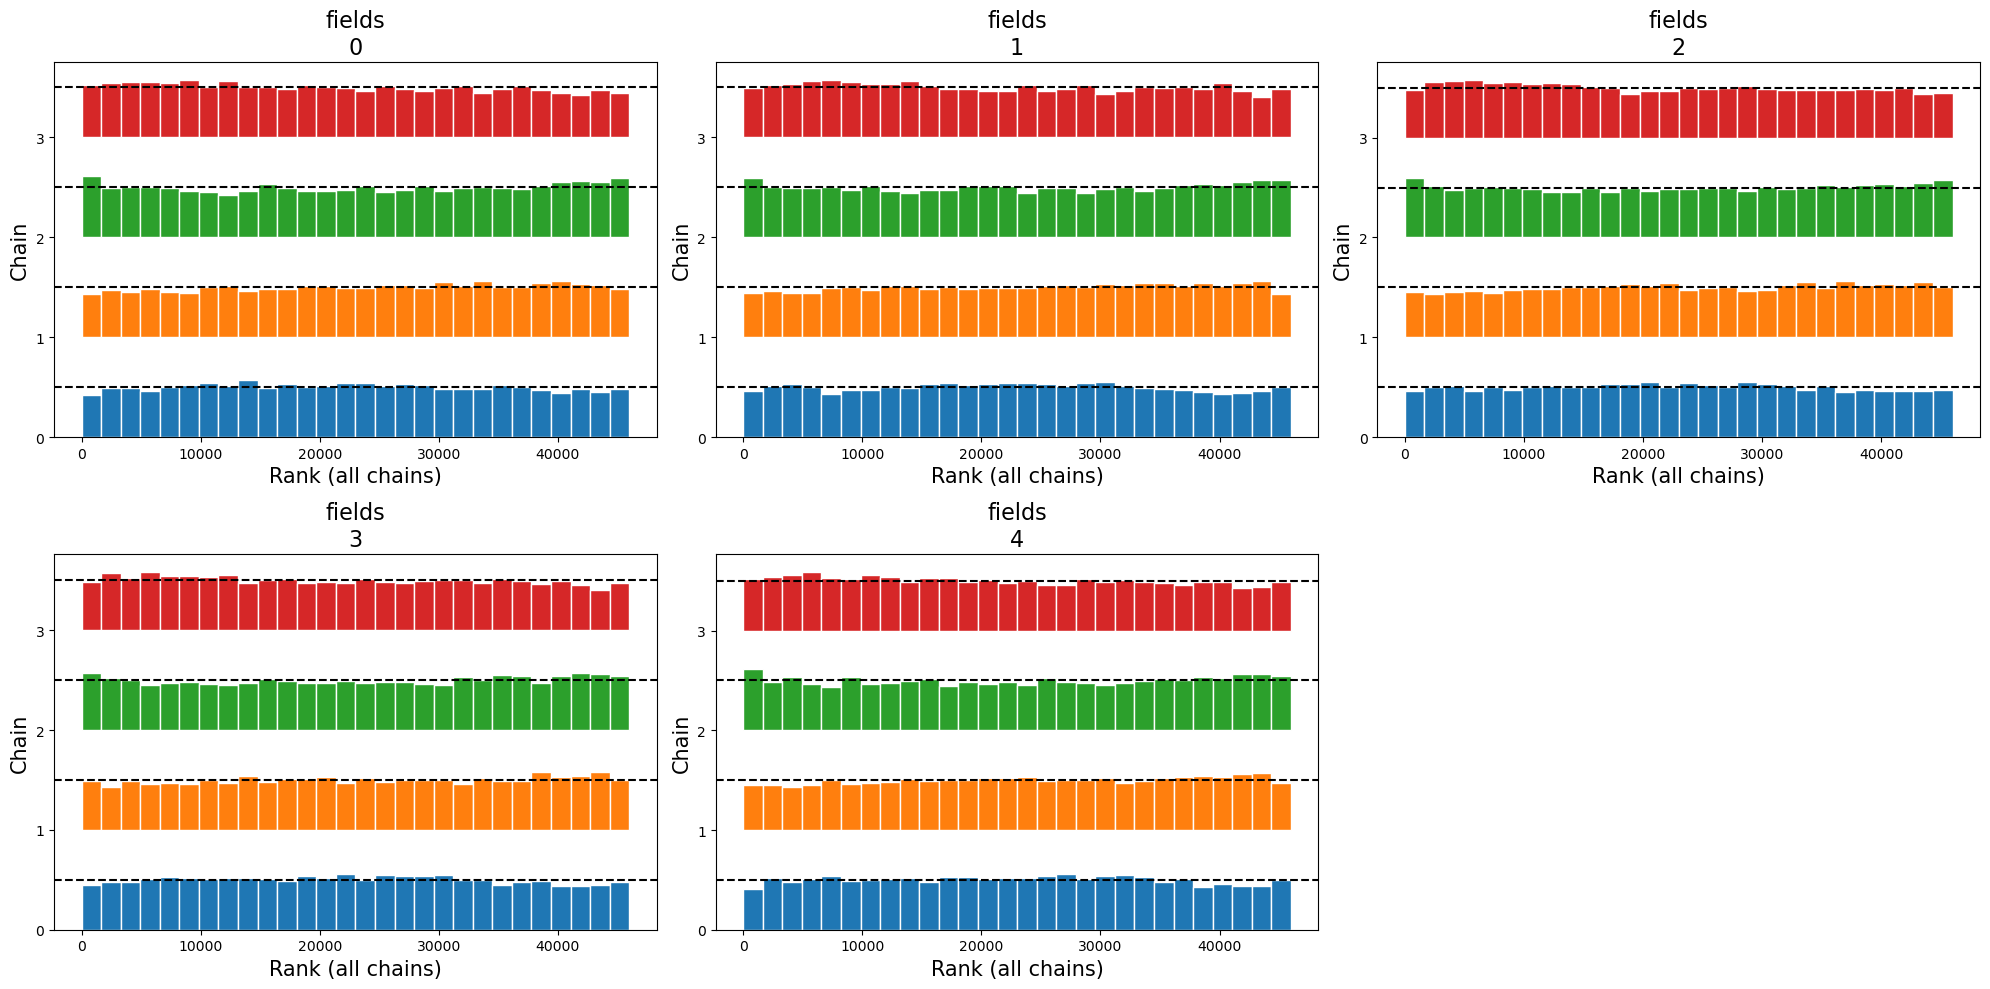

In [12]:
# rank plots for topic
# these look a bit worse than for the other models!!
az.plot_rank(trace_field_thurstonian_all, var_names=["fields"], figsize=(20, 10))

plt.tight_layout()

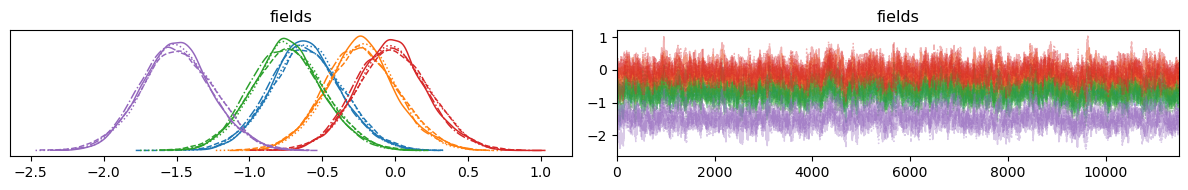

In [13]:
# trace plots
# cannot plot trace for all parameters

az.plot_trace(trace_field_thurstonian_all, var_names=["fields"])
plt.tight_layout()

In [14]:
# main sampling stats

az.summary(trace_field_thurstonian_all, var_names=["fields"]).iloc[:, 4:]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fields[0],0.009,0.006,744.0,1624.0,1.0
fields[1],0.009,0.006,756.0,1702.0,1.0
fields[2],0.009,0.006,748.0,1591.0,1.0
fields[3],0.009,0.006,746.0,1651.0,1.0
fields[4],0.009,0.006,748.0,1598.0,1.0


In [15]:
# check rhats and divergences

# rhats
vars = [
    "fields",
    "paper_intercepts",
    "strictness_sd",
    "strictness_offset1",
    "strictness_offset2",
    "strictness_offset3",
]
summary = az.summary(trace_field_thurstonian_all, var_names=vars)
high_rhats = [i for i in summary["r_hat"] if i > 1.0]

if len(high_rhats) > 0:
    print(
        f"Prop of rhats > 1: {(len(high_rhats) / len(summary)):.2f}; Highest rhat: {np.array(high_rhats).max()}"
    )
else:
    print("No rhats higher than 1.0")

# divergences
divergences = trace_field_thurstonian_all.sample_stats["diverging"]
print(f"Nr of divergences: {divergences.sum().values}")

No rhats higher than 1.0
Nr of divergences: 0


## Results

In [16]:
summary = az.summary(trace_field_thurstonian_all, var_names=["fields"])
summary.index = fields_order
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
History,-0.611,0.246,-1.069,-0.137,0.009,0.006,744.0,1624.0,1.0
Philosophy,-0.232,0.246,-0.698,0.238,0.009,0.006,756.0,1702.0,1.0
Religion,-0.736,0.247,-1.206,-0.273,0.009,0.006,748.0,1591.0,1.0
Linguistics,-0.021,0.248,-0.480,0.458,0.009,0.006,746.0,1651.0,1.0
Literature,-1.496,0.247,-1.943,-1.016,0.009,0.006,748.0,1598.0,1.0


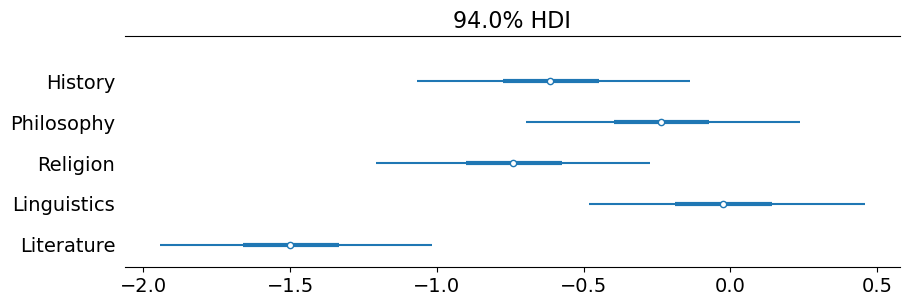

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
az.plot_forest(trace_field_thurstonian_all, var_names=["fields"], combined=True, ax=ax)
fields_order_reversed = list(reversed(fields_order))
ax.set_yticklabels(fields_order_reversed)
plt.show()

# Check strictness

We can check the results using any of the three models.
Note: the general gist is the same, but there are differences in the precise values. Are the models not on the same scale?

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

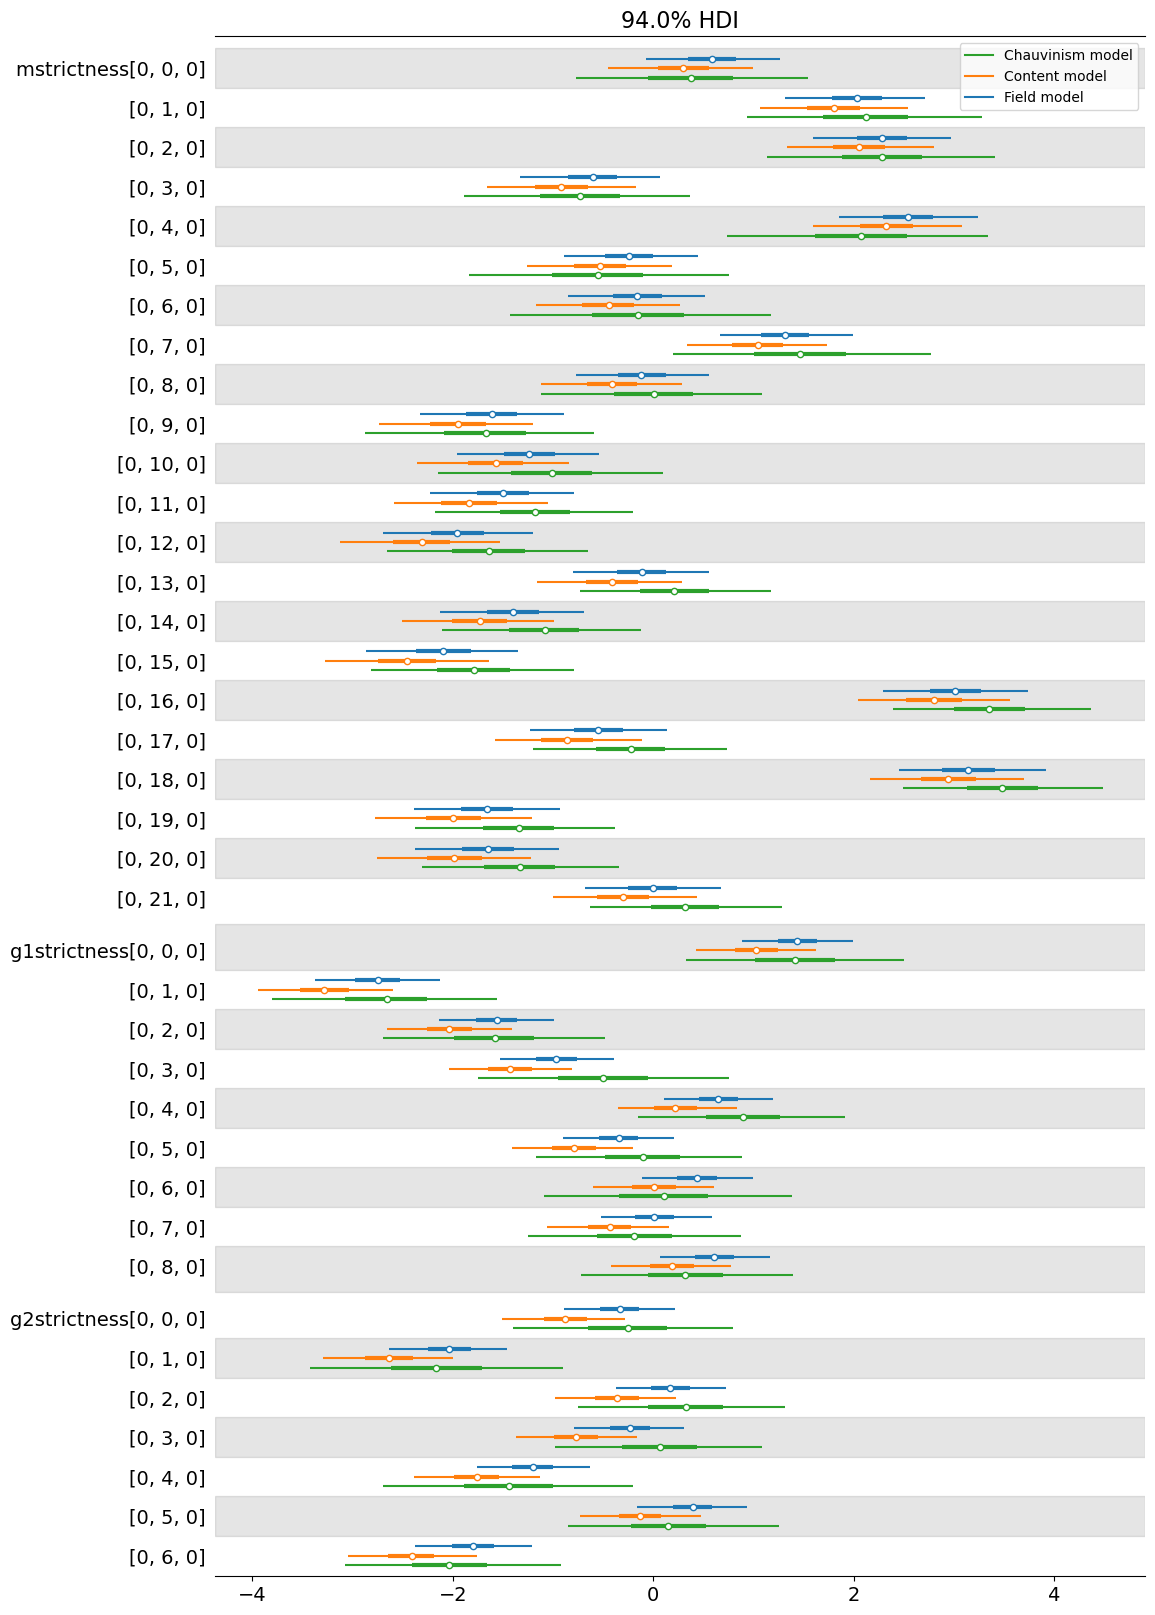

In [159]:
models = [
    trace_field_thurstonian_all,
    trace_content_thurstonian_all,
    trace_chauvinism_thurstonian_all,
]
az.plot_forest(
    models,
    var_names=["mstrictness", "g1strictness", "g2strictness"],
    model_names=["Field model", "Content model", "Chauvinism model"],
    combined=True,
    figsize=(12, 20),
)

In [160]:
az.summary(
    trace_field_thurstonian_all,
    var_names=["mstrictness", "g1strictness", "g2strictness"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mstrictness[0, 0, 0]",0.585,0.356,-0.077,1.264,0.009,0.006,1555.0,4795.0,1.0
"mstrictness[0, 1, 0]",2.035,0.371,1.319,2.716,0.009,0.006,1680.0,5196.0,1.0
"mstrictness[0, 2, 0]",2.287,0.370,1.591,2.976,0.009,0.007,1598.0,5224.0,1.0
"mstrictness[0, 3, 0]",-0.608,0.371,-1.332,0.070,0.009,0.007,1619.0,4916.0,1.0
"mstrictness[0, 4, 0]",2.546,0.371,1.858,3.246,0.009,0.007,1622.0,5267.0,1.0
"mstrictness[0, 5, 0]",-0.238,0.358,-0.894,0.451,0.009,0.007,1461.0,4400.0,1.0
"mstrictness[0, 6, 0]",-0.159,0.364,-0.847,0.520,0.009,0.006,1611.0,4984.0,1.0
"mstrictness[0, 7, 0]",1.317,0.355,0.664,1.998,0.009,0.007,1490.0,4557.0,1.0
"mstrictness[0, 8, 0]",-0.116,0.354,-0.774,0.560,0.009,0.006,1495.0,4560.0,1.0
"mstrictness[0, 9, 0]",-1.615,0.383,-2.324,-0.886,0.009,0.006,1757.0,5550.0,1.0


In [161]:
az.summary(
    trace_content_thurstonian_all,
    var_names=["mstrictness", "g1strictness", "g2strictness"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mstrictness[0, 0, 0]",0.299,0.383,-0.447,0.996,0.012,0.008,1101.0,3588.0,1.00
"mstrictness[0, 1, 0]",1.802,0.393,1.066,2.541,0.011,0.008,1200.0,4016.0,1.00
"mstrictness[0, 2, 0]",2.053,0.391,1.330,2.800,0.011,0.008,1173.0,3574.0,1.01
"mstrictness[0, 3, 0]",-0.919,0.392,-1.656,-0.176,0.012,0.008,1156.0,3063.0,1.01
"mstrictness[0, 4, 0]",2.323,0.393,1.595,3.077,0.011,0.008,1196.0,3889.0,1.00
"mstrictness[0, 5, 0]",-0.534,0.386,-1.259,0.191,0.012,0.008,1129.0,3625.0,1.01
"mstrictness[0, 6, 0]",-0.450,0.386,-1.173,0.272,0.011,0.008,1153.0,4213.0,1.01
"mstrictness[0, 7, 0]",1.041,0.376,0.338,1.738,0.011,0.008,1093.0,3264.0,1.01
"mstrictness[0, 8, 0]",-0.413,0.374,-1.121,0.286,0.011,0.008,1072.0,3871.0,1.01
"mstrictness[0, 9, 0]",-1.952,0.409,-2.734,-1.204,0.012,0.008,1221.0,4219.0,1.01


In [162]:
az.summary(
    trace_chauvinism_thurstonian_all,
    var_names=["mstrictness", "g1strictness", "g2strictness"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mstrictness[0, 0, 0]",0.371,0.620,-0.774,1.542,0.022,0.015,816.0,1995.0,1.01
"mstrictness[0, 1, 0]",2.123,0.624,0.932,3.276,0.022,0.015,817.0,1766.0,1.01
"mstrictness[0, 2, 0]",2.287,0.602,1.137,3.415,0.020,0.014,871.0,2064.0,1.00
"mstrictness[0, 3, 0]",-0.726,0.598,-1.886,0.369,0.020,0.014,883.0,2121.0,1.00
"mstrictness[0, 4, 0]",2.070,0.692,0.732,3.344,0.024,0.017,863.0,2231.0,1.01
"mstrictness[0, 5, 0]",-0.558,0.686,-1.836,0.754,0.023,0.017,856.0,2213.0,1.01
"mstrictness[0, 6, 0]",-0.152,0.687,-1.427,1.172,0.023,0.017,864.0,2612.0,1.00
"mstrictness[0, 7, 0]",1.465,0.686,0.197,2.769,0.024,0.017,834.0,2616.0,1.00
"mstrictness[0, 8, 0]",0.002,0.587,-1.120,1.087,0.019,0.014,925.0,2100.0,1.00
"mstrictness[0, 9, 0]",-1.682,0.606,-2.877,-0.595,0.019,0.014,995.0,2704.0,1.00
